In [1]:
!pip install torchsummary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchsummary as summary
import time
import torch
from torch import nn
import torchvision
from torchvision import models,transforms
from torch.utils.data import DataLoader,Dataset
import os
from PIL import Image

In [3]:
!nvidia-smi

Mon Sep  6 11:37:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class_dict=pd.read_csv("../input/100-bird-species/birds_rev2/class_dict.csv")
class_dict

,class_index,class,height,width,scale by
0,0.0,AFRICAN CROWNED CRANE,224,224,1
1,1.0,AFRICAN FIREFINCH,224,224,1
2,2.0,ALBATROSS,224,224,1
3,3.0,ALEXANDRINE PARAKEET,224,224,1
4,4.0,AMERICAN AVOCET,224,224,1
...,...,...,...,...,...
812,NaN,NaN,224,224,1
813,NaN,NaN,224,224,1
814,NaN,NaN,224,224,1
815,NaN,NaN,224,224,1


In [6]:
bird_data=pd.read_csv("../input/100-bird-species/birds_rev2/birds.csv")
bird_data

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
42109,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
42110,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
42111,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
42112,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [7]:
train_path=os.listdir("../input/100-bird-species/birds_rev2/train")
val_path=os.listdir("../input/100-bird-species/birds_rev2/valid")
test_path=os.listdir("../input/100-bird-species/birds_rev2/test")

In [8]:
a=class_dict['class'].unique()[:-1]
name_dict=dict(zip(a,np.arange(275)))


In [9]:
bird_data['data set'].unique()

array(['train', 'test', 'valid'], dtype=object)

In [10]:
train_pd=bird_data[bird_data['data set']=='train']
train_pd

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
39359,train/YELLOW HEADED BLACKBIRD/155.jpg,YELLOW HEADED BLACKBIRD,train
39360,train/YELLOW HEADED BLACKBIRD/156.jpg,YELLOW HEADED BLACKBIRD,train
39361,train/YELLOW HEADED BLACKBIRD/157.jpg,YELLOW HEADED BLACKBIRD,train
39362,train/YELLOW HEADED BLACKBIRD/158.jpg,YELLOW HEADED BLACKBIRD,train


In [11]:
val_pd=pd.DataFrame(bird_data[bird_data['data set']=='valid'].values,columns=['filepaths','labels','data set'])
val_pd

,filepaths,labels,data set
0,valid/AFRICAN CROWNED CRANE/1.jpg,AFRICAN CROWNED CRANE,valid
1,valid/AFRICAN CROWNED CRANE/2.jpg,AFRICAN CROWNED CRANE,valid
2,valid/AFRICAN CROWNED CRANE/3.jpg,AFRICAN CROWNED CRANE,valid
3,valid/AFRICAN CROWNED CRANE/4.jpg,AFRICAN CROWNED CRANE,valid
4,valid/AFRICAN CROWNED CRANE/5.jpg,AFRICAN CROWNED CRANE,valid
...,...,...,...
1370,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
1371,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
1372,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
1373,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [12]:
test_pd=pd.DataFrame(bird_data[bird_data['data set']=='test'].values,columns=['filepaths','labels','data set'])
test_pd

,filepaths,labels,data set
0,test/AFRICAN CROWNED CRANE/1.jpg,AFRICAN CROWNED CRANE,test
1,test/AFRICAN CROWNED CRANE/2.jpg,AFRICAN CROWNED CRANE,test
2,test/AFRICAN CROWNED CRANE/3.jpg,AFRICAN CROWNED CRANE,test
3,test/AFRICAN CROWNED CRANE/4.jpg,AFRICAN CROWNED CRANE,test
4,test/AFRICAN CROWNED CRANE/5.jpg,AFRICAN CROWNED CRANE,test
...,...,...,...
1370,test/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,test
1371,test/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,test
1372,test/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,test
1373,test/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,test


#计算整个数据集图片的均值和方差
from imageio import imread

filepath = '../input/100-bird-species/birds_rev2'  # 数据集目录

pathDir = train_pd['filepaths']

R_channel = 0
G_channel = 0
B_channel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = imread(os.path.join(filepath, filename))/255.0
    R_channel = R_channel + np.sum(img[:, :, 0])
    G_channel = G_channel + np.sum(img[:, :, 1])
    B_channel = B_channel + np.sum(img[:, :, 2])
 
num = len(pathDir) * 224*224  # 这里（1024,1024）是每幅图片的大小，所有图片尺寸都一样
R_mean = R_channel / num  # or /255.0
G_mean = G_channel / num 
B_mean = B_channel / num 
 
R_channel = 0
G_channel = 0
B_channel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = imread(os.path.join(filepath, filename))/255.0
    R_channel = R_channel + np.sum((img[:, :, 0] - R_mean) ** 2)
    G_channel = G_channel + np.sum((img[:, :, 1] - G_mean) ** 2)
    B_channel = B_channel + np.sum((img[:, :, 2] - B_mean) ** 2)
 
R_var = np.sqrt(R_channel / num)
G_var = np.sqrt(G_channel / num)
B_var = np.sqrt(B_channel / num)
print("R_mean is %f, G_mean is %f, B_mean is %f" % (R_mean, G_mean, B_mean))
print("R_var is %f, G_var is %f, B_var is %f" % (R_var, G_var, B_var))
# R_mean is 0.469289, G_mean is 0.467588, B_mean is 0.393907
# R_var is 0.238269, G_var is 0.232191, B_var is 0.254105

In [13]:
class birddataset(Dataset):
    def __init__(self,in_pd,name_dict,transform):
        self.inpd=in_pd
        self.name_dict=name_dict
        self.transform=transform
    def __len__(self):
        return len(self.inpd)
    def __getitem__(self,idx):
        img=Image.open(os.path.join("../input/100-bird-species/birds_rev2",self.inpd['filepaths'][idx]))
        label=torch.tensor(name_dict[self.inpd['labels'][idx]]).to(device)
        img=transform(img).to(device)
        return img,label

In [14]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.469289, 0.467588, 0.393907), (1,1,1))])

In [15]:
train_dataset=birddataset(train_pd,name_dict,transform)
val_dataset=birddataset(val_pd,name_dict,transform)
test_dataset=birddataset(test_pd,name_dict,transform)


In [16]:
batchsize=256

In [17]:
train_dataloader=DataLoader(train_dataset,batchsize,shuffle=True)
val_dataloader=DataLoader(val_dataset,batchsize,shuffle=True)
test_dataloader=DataLoader(test_dataset,batchsize,shuffle=True)

In [18]:
class inception(nn.Module):
    def __init__(self,in_ch,ch1x1,ch3x3_re,ch3x3,ch5x5_re,ch5x5,pool):
        super(inception,self).__init__()
        self.in_ch=in_ch
        self.ch1x1=ch1x1
        self.ch3x3_re=ch3x3_re
        self.ch3x3=ch3x3
        self.ch5x5_re=ch5x5_re
        self.ch5x5=ch5x5
        self.pool=pool
        self.layer1=nn.Sequential(
            nn.Conv2d(self.in_ch,self.ch1x1,kernel_size=1),
            nn.BatchNorm2d(self.ch1x1),
            nn.ReLU(),
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(self.in_ch,self.ch3x3_re,kernel_size=1),
            nn.BatchNorm2d(self.ch3x3_re),
            nn.ReLU(),
            nn.Conv2d(self.ch3x3_re,self.ch3x3,kernel_size=3,padding=1),
            nn.BatchNorm2d(self.ch3x3),
            nn.ReLU(),
        )
        self.layer3=nn.Sequential(
            nn.Conv2d(self.in_ch,self.ch5x5_re,kernel_size=1),
            nn.BatchNorm2d(self.ch5x5_re),
            nn.ReLU(),
            # Here, kernel_size=3 instead of kernel_size=5 is a known bug.????
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            nn.Conv2d(self.ch5x5_re,self.ch5x5,kernel_size=3,padding=1),
            nn.BatchNorm2d(self.ch5x5),
            nn.ReLU(),
        )
        self.layer4=nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            nn.Conv2d(self.in_ch,self.pool,kernel_size=1),
            nn.BatchNorm2d(self.pool),
            nn.ReLU(),
        )
    def forward(self,x):
        x1=self.layer1(x)
        x2=self.layer2(x)
        x3=self.layer3(x)
        x4=self.layer4(x)
        x=[x1,x2,x3,x4]
        x=torch.cat(x,1)
        return x

In [19]:
class inceptionaux(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(inceptionaux,self).__init__()
        self.in_ch=in_ch
        self.out_ch=out_ch
        self.layer=nn.Sequential(
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Conv2d(self.in_ch,128,kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048,1024),
            nn.Linear(1024,self.out_ch),
        )
    def forward(self,x):
        x=self.layer(x)
        return x

In [20]:
class googlenet(nn.Module):
    def __init__(self,out_ch,trainau=True):
        super(googlenet,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2,ceil_mode=True),
            nn.Conv2d(64,64,kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,192,kernel_size=3,padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(3,stride=2,ceil_mode=True)
        )
        self.layer3a=inception(192,64,96,128,16,32,32)
        self.layer3b=inception(256,128,128,192,32,96,64)
        self.maxpool3=nn.MaxPool2d(3,stride=2,ceil_mode=True)
        self.layer4a=inception(480,192,96,208,16,48,64)
        self.layer4b=inception(512,160,112,224,24,64,64)
        self.aux1=inceptionaux(512,out_ch)
        self.layer4c=inception(512,128,128,256,24,64,64)
        self.layer4d=inception(512,112,144,288,32,64,64)
        self.aux2=inceptionaux(528,out_ch)
        self.layer4e=inception(528,256,160,320,32,128,128)
        self.maxpool4=nn.MaxPool2d(3,stride=2,ceil_mode=True)
        self.layer5a=inception(832,256,160,320,32,128,128)
        self.layer5b=inception(832,384,192,384,48,128,128)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.dropout=nn.Dropout(0.2)
        self.FC=nn.Linear(1024,out_ch)
        #self.softmax=nn.Softmax(dim=1)
        self.trainau=trainau
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer3a(x)
        x=self.layer3b(x)
        x=self.maxpool3(x)
        x=self.layer4a(x)
        if self.trainau:
            auc1=self.aux1(x)
        x=self.layer4b(x)
        x=self.layer4c(x)
        x=self.layer4d(x)
        if self.trainau:
            auc2=self.aux2(x)
        x=self.layer4e(x)
        x=self.maxpool4(x)
        x=self.layer5a(x)
        x=self.layer5b(x)
        x=self.avgpool(x)
        x=nn.Flatten()(x)
        x=self.dropout(x)
        x=self.FC(x)
        #x=self.softmax(x)
        if self.trainau:
            return x,auc1,auc2
        else:
            return x

In [21]:
googlenet1=googlenet(275)
googlenet1=googlenet1.to(device)
googlenet1

googlenet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer3a): inception(
    (layer1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): Conv2

In [22]:
summary.summary(googlenet1,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

In [23]:
googlenet_pro=torchvision.models.GoogLeNet().to(device)
summary.summary(googlenet_pro,(3,224,224))

/opt/conda/lib/python3.7/site-packages/torchvision/models/googlenet.py:73: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [24]:
optim=torch.optim.SGD(googlenet1.parameters(),0.01)
loss=torch.nn.CrossEntropyLoss().to(device)

In [25]:
epoc=40

In [26]:
train_cost_array=np.zeros(epoc*2)
train_acc_array=np.zeros(epoc*2)
val_cost_array=np.zeros(epoc*2)
val_acc_array=np.zeros(epoc*2)
for i in range(epoc):
    train_cost=0
    train_acc=0
    val_cost=0
    val_acc=0
    step=0
    train_start=time.time()
    googlenet1.train()
    for img,lab in train_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        optim.zero_grad()
        y_hat,y_auc1,y_auc2=googlenet1(img)#y_hat=googlenet1(img)#
        res_loss=loss(y_hat,lab)+0.3*loss(y_auc1,lab)+0.3*loss(y_auc2,lab)#res_loss=loss(y_hat,lab)#
        train_cost=train_cost+res_loss*len(lab)
        train_acc=train_acc+(y_hat.argmax(1)==lab).sum()
        step=step+1
        res_loss.backward()
        optim.step()
        if step%100==0:
            print(f"epoc: {i},step: {step},cost: {res_loss},acc count: {train_acc},acc: {train_acc/len(train_dataset)}\n")
    train_acc_array[i]=train_acc.item()/len(train_dataset)
    train_cost_array[i]=train_cost.item()/len(train_dataset)
    train_end=time.time()
    print('*'*100+'\n')
    print(f"epoc: {i},cost: {train_cost},acc count: {train_acc},acc: {train_acc/len(train_dataset)},time: {train_end-train_start}\n")
    googlenet1.eval()
    val_start=time.time()
    with torch.no_grad():
        for img,lab in val_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat,y_auc1,y_auc2=googlenet1(img)#y_hat=googlenet1(img)#
            res_loss=loss(y_hat,lab)+0.3*loss(y_auc1,lab)+0.3*loss(y_auc2,lab)#res_loss=loss(y_hat,lab)#
            val_cost=val_cost+res_loss*len(lab)
            val_acc=val_acc+(y_hat.argmax(1)==lab).sum()
        val_acc_array[i]=val_acc.item()/len(val_dataset)
        val_cost_array[i]=val_cost.item()/(len(val_dataset))
        val_end=time.time()
        print(f"epoc: {i},cost: {val_cost},acc count: {val_acc},acc: {val_acc/len(val_dataset)},time: {val_end-val_start}\n")
        print('*'*100+'\n')

epoc: 0,step: 100,cost: 8.828513145446777,acc count: 267,acc: 0.006782847456634045

****************************************************************************************************

epoc: 0,cost: 349216.90625,acc count: 575,acc: 0.014607255347073078,time: 380.74495482444763

epoc: 0,cost: 11817.501953125,acc count: 55,acc: 0.03999999910593033,time: 10.369069814682007

****************************************************************************************************

epoc: 1,step: 100,cost: 8.382767677307129,acc count: 1169,acc: 0.02969718538224697

****************************************************************************************************

epoc: 1,cost: 334200.78125,acc count: 1943,acc: 0.049359820783138275,time: 206.32312846183777

epoc: 1,cost: 11216.8994140625,acc count: 88,acc: 0.06399999558925629,time: 4.644581079483032

****************************************************************************************************

epoc: 2,step: 100,cost: 8.058361053466797,acc

In [27]:
optim=torch.optim.SGD(googlenet1.parameters(),0.001)

In [28]:
for i in range(epoc):
    train_cost=0
    train_acc=0
    val_cost=0
    val_acc=0
    step=0
    train_start=time.time()
    googlenet1.train()
    for img,lab in train_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        optim.zero_grad()
        y_hat,y_auc1,y_auc2=googlenet1(img)#y_hat=googlenet1(img)#
        res_loss=loss(y_hat,lab)+0.3*loss(y_auc1,lab)+0.3*loss(y_auc2,lab)#res_loss=loss(y_hat,lab)#
        train_cost=train_cost+res_loss*len(lab)
        train_acc=train_acc+(y_hat.argmax(1)==lab).sum()
        step=step+1
        res_loss.backward()
        optim.step()
        if step%100==0:
            print(f"epoc: {epoc+i},step: {step},cost: {res_loss},acc count: {train_acc},acc: {train_acc/len(train_dataset)}\n")
    train_acc_array[epoc+i]=train_acc.item()/len(train_dataset)
    train_cost_array[epoc+i]=train_cost.item()/len(train_dataset)
    train_end=time.time()
    print('*'*100+'\n')
    print(f"epoc: {epoc+i},cost: {train_cost},acc count: {train_acc},acc: {train_acc/len(train_dataset)},time: {train_end-train_start}\n")
    googlenet1.eval()
    val_start=time.time()
    with torch.no_grad():
        for img,lab in val_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat,y_auc1,y_auc2=googlenet1(img)#y_hat=googlenet1(img)#
            res_loss=loss(y_hat,lab)+0.3*loss(y_auc1,lab)+0.3*loss(y_auc2,lab)#res_loss=loss(y_hat,lab)#
            val_cost=val_cost+res_loss*len(lab)
            val_acc=val_acc+(y_hat.argmax(1)==lab).sum()
        val_acc_array[epoc+i]=val_acc.item()/len(val_dataset)
        val_cost_array[epoc+i]=val_cost.item()/(len(val_dataset))
        val_end=time.time()
        print(f"epoc: {epoc+i},cost: {val_cost},acc count: {val_acc},acc: {val_acc/len(val_dataset)},time: {val_end-val_start}\n")
        print('*'*100+'\n')

epoc: 40,step: 100,cost: 0.9470949769020081,acc count: 24864,acc: 0.6316431164741516

****************************************************************************************************

epoc: 40,cost: 34925.1015625,acc count: 38310,acc: 0.9732242822647095,time: 205.5014021396637

epoc: 40,cost: 2215.14453125,acc count: 1096,acc: 0.7970908880233765,time: 4.700227975845337

****************************************************************************************************

epoc: 41,step: 100,cost: 0.8990209698677063,acc count: 25096,acc: 0.6375368237495422

****************************************************************************************************

epoc: 41,cost: 33299.9921875,acc count: 38560,acc: 0.9795752167701721,time: 206.08371710777283

epoc: 41,cost: 2208.2822265625,acc count: 1102,acc: 0.8014545440673828,time: 4.933020830154419

****************************************************************************************************

epoc: 42,step: 100,cost: 0.805614531040

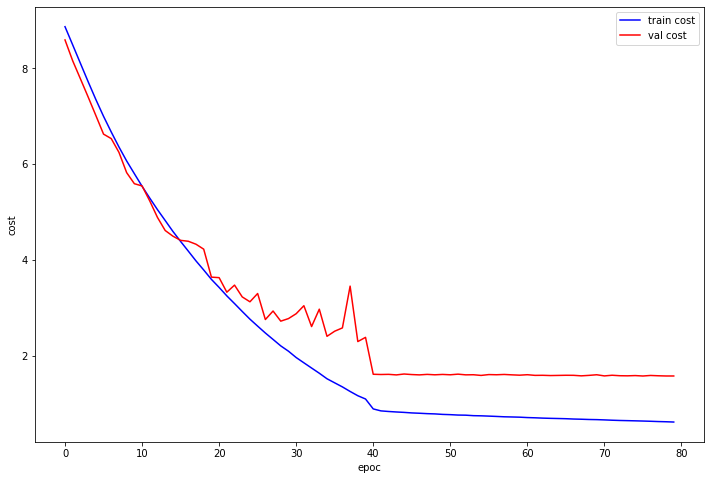

In [29]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(epoc*2),train_cost_array,c='b',label='train cost')
plt.plot(np.arange(epoc*2),val_cost_array,c='r',label='val cost')
plt.xlabel('epoc')
plt.ylabel('cost')
plt.legend()



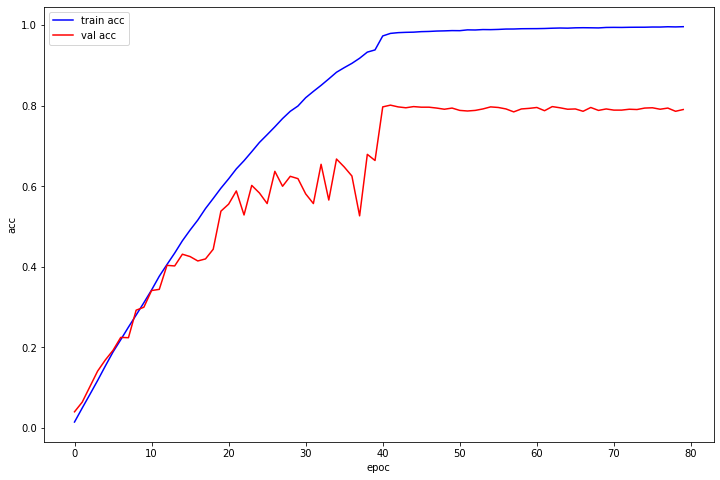

In [30]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(epoc*2),train_acc_array,c='b',label='train acc')
plt.plot(np.arange(epoc*2),val_acc_array,c='r',label='val acc')
plt.xlabel('epoc')
plt.ylabel('acc')

plt.legend()

In [31]:
googlenet1.eval()
test_cost=0
test_acc=0
with torch.no_grad():
    for img,lab in test_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat,y_auc1,y_auc2=googlenet1(img)
            res_loss=loss(y_hat,lab)+0.3*loss(y_auc1,lab)+0.3*loss(y_auc2,lab)
            test_cost=test_cost+res_loss*len(lab)
            test_acc=test_acc+(y_hat.argmax(1)==lab).sum()
print(f"test acc count: {test_acc},test acc: {test_acc.item()/len(test_dataset)},test cost: {test_cost}\n")

test acc count: 1135,test acc: 0.8254545454545454,test cost: 1957.6348876953125



In [32]:
torch.save(googlenet1.state_dict(),'googlenet.pth')